## Observations and Insights 
*Note: I got a lot of help from my tutor for this homework. Much of the initial code she gave me at first I did not understand, so I just put in the code that she suggested and ran it, then went back and looked over it and wrote out what I believed it to be doing. I have tracked my time that I've spent outside of class this week and this homework is the result of 13 hours of work. 

1. The summary statistic table for tumor size is a relatively low SEM for all drug regimens, meaning that the drug results on tumor size in a general population of mice should not be very different than the drug results on tumor size in the sample population of the study.
 
2. We see a strong correlation coefficient--.84-- between the average size of tumor and the
   mouse weight for mice within the Capomulin regimen. This shows that the heavier the mouse,
   the larger the average tumor size will be for mice in this regiment, and we can be fairly confident that this trend will continue.
  
3.  We saw a significant decrease of tumor volume over time in a single mouse (s185) treated with Capomulin.
    It would be helpful if we assessed whether this trend also characterizes the entire
    group of mice that were under this regimen, and perhaps compared the results to 
    groups of mice under other regiments.
 
4. There was a nearly equal distribution of sex across the total population of mice, about 49% 
   female and 51% male. Therefore it seems unlikely that sex played a significant factor in 
   determining outcomes from these studies, at least at the aggregate level.
 
5. The boxplots indicate that all the quartiles for Capomulin and Ramican mice populations were significantly smaller than the Infubinol and Ceftamin regimens. We can deduce from this that overwhelming majority of the mice in the Capomulin and Ramican regimens had smaller tumor volumes at the end of the trials than did the mice under the Infubinol and Ceftamin regimens.

In [78]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import scipy.stats as st
import random
import numpy as np
from scipy.stats import sem
from scipy.stats import linregress



# Study data files
mouse_metadata_path = "Mouse_metadata.csv"
study_results_path = "Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)


# Combine the data into a single dataset.  
#we merge the dataset, keeping every row from the metadata frame and adding the rows of 
#data from the study_results dataframe. We merge 'on' mouse ID.
unfiltered_data_and_results = pd.merge(mouse_metadata, study_results, how="left", on=["Mouse ID"])

# Display the data table for preview
unfiltered_data_and_results.head()


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [79]:
#Before beginning the analysis, check the data for any mouse ID 
#with duplicate time points and remove any data associated with that mouse ID 
#(i.e., exclude that mouse from the analysis). 

# Identify incomplete rows. First,we count the rows just to know how many we have.
unfiltered_data_and_results.count()
# Then, we drop all rows with missing information using the .loc function 
#to find the duplicates within the "Mouse ID" and "Timepoint" column, but retain the mouse ID column
duplicate_id = unfiltered_data_and_results.loc[unfiltered_data_and_results.duplicated(subset = ["Mouse ID", "Timepoint"]), "Mouse ID"]
# Verify dropped rows
duplicate_id.unique()
#we create a new dataframe, which is the unfiltered data minus the duplicated Mouse ID values
data_and_results = unfiltered_data_and_results[unfiltered_data_and_results["Mouse ID"].isin(duplicate_id) == False]

data_and_results.head()


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [80]:
# Check the number of mice.
#We do this by using the len function on the count of unique values in the Mouse ID list
num_of_mice = len(data_and_results['Mouse ID'].unique())
num_of_mice


248

In [81]:
# Optional: Get all the data for the duplicate mouse ID. 


In [82]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
#Optional
data_and_results.drop_duplicates(['Mouse ID'], keep = 'first')
# https://www.youtube.com/watch?v=MxYEwXnqdNQ

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.0,0
10,s185,Capomulin,Female,3,17,0,45.0,0
20,x401,Capomulin,Female,16,15,0,45.0,0
30,m601,Capomulin,Male,22,17,0,45.0,0
40,g791,Ramicane,Male,11,16,0,45.0,0
...,...,...,...,...,...,...,...,...
1858,z314,Stelasyn,Female,21,28,0,45.0,0
1860,z435,Propriva,Female,12,26,0,45.0,0
1863,z581,Infubinol,Female,24,25,0,45.0,0
1873,z795,Naftisol,Female,13,29,0,45.0,0


In [83]:
# Check the number of mice in the clean DataFrame.
num_of_mice = len(data_and_results['Mouse ID'].unique())
num_of_mice


248

## Summary Statistics

In [84]:
# Method 1:  Generate a summary statistics table of mean, median, variance, standard deviation,
#and SEM of the tumor volume for each regimen
#Interesting that the needed libraries didnt' come with the starter code? Oh well. I put it in at the start.

#here, we split the data_and_results dataframe into drug regimen groups and take the mean value of the tumor volume/
mean_tumors = data_and_results.groupby(["Drug Regimen"]).mean()["Tumor Volume (mm3)"]
mean_tumors
#we do the same here and take the median value
median_tumors = data_and_results.groupby(["Drug Regimen"]).median()["Tumor Volume (mm3)"]
mean_tumors

#we do the same here and take the variance
var_tumors = data_and_results.groupby(["Drug Regimen"]).var()["Tumor Volume (mm3)"]

#we do the same here and take the standard deviation
standdev_tumors = data_and_results.groupby(["Drug Regimen"]).std()["Tumor Volume (mm3)"]

#We do the same here and take the SEM
sem_tumors = data_and_results.groupby(["Drug Regimen"]).sem()["Tumor Volume (mm3)"]
sem_tumors

#we create a dataframe of a dictionary, the keys are the names of the columnn we are creating
#and the values are the mean, median, and so on for each drug regimen.
summary_df = pd.DataFrame({"mean": mean_tumors, "median": median_tumors, "variance": var_tumors, "standard deviation": standdev_tumors, "SEM":sem_tumors})
summary_df



,mean,median,variance,standard deviation,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [85]:
# Method 2(optional): 
#Generate a summary statistics table of mean, median, variance, standard deviation, and SEM 
#of the tumor volume for each regimen

#We create a new df by splitting the data_and_results df into regimen groups, then running the agg
#function on a dictionary we create in which tumor volume is the key and the mean, median, var, and so on are the values.
summary1_df = data_and_results.groupby(["Drug Regimen"]).agg({"Tumor Volume (mm3)":["mean", "median", "var", "std", "sem"]})
summary1_df
# This method produces everything in a single groupby function. 
#(https://pandas.pydata.org/pandas-docs/version/0.22.0/generated/pandas.core.groupby.DataFrameGroupBy.agg.html)


Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

## Bar and Pie Charts

Text(0.5, 1.0, 'Number of Mice in each Drug Regiment')

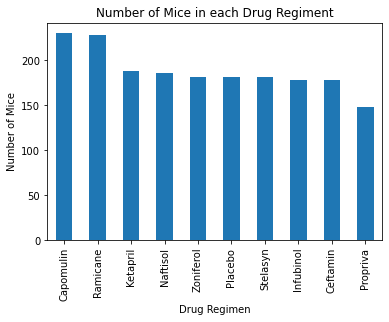

In [86]:
# Use Pandas to generate a bar plot showing the total number of mice in each treatment regimen 
#throughout the course of the study. 

#we create a dataframe simply of the value_counts of drug regimen column, which counts the # of mice 
#in each drug regimen column.

mice_count = data_and_results["Drug Regimen"].value_counts()
#Then we plot it as a bar and add appropriate labels
mice_count.plot(kind = "bar")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Mice")
plt.title("Number of Mice in each Drug Regiment")

## Note: this plot will be identical to the one that uses Pyplot

In [87]:
mice_count

Capomulin    230
Ramicane     228
Ketapril     188
Naftisol     186
Zoniferol    182
Placebo      181
Stelasyn     181
Infubinol    178
Ceftamin     178
Propriva     148
Name: Drug Regimen, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

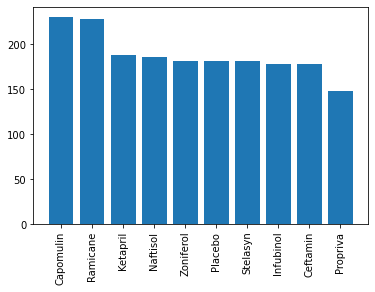

In [88]:
# Use Pyplot to generate a bar plot showing the total number of mice treatment in each treatment 
#regimen throughout the course of the study.

#we create a bar chart with the index (regimen names) as the x-axis, and the # of mice as the y-axis.

plt.bar(mice_count.index.values, mice_count.values)
plt.xticks(rotation = 90)
##  Note: this plot will be identical to the one that uses Pandas

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


([<matplotlib.patches.Wedge at 0x7fa28864f550>,
 [Text(-1.0127715849027383, 0.5447877722687946, 'Male'),
  Text(0.9687380377330536, -0.5211013473875431, 'Female')],
 [Text(-0.5724361132058955, 0.30792352345627516, '51.0%'),
  Text(0.5284025660362109, -0.2842370985750235, '49.0%')])

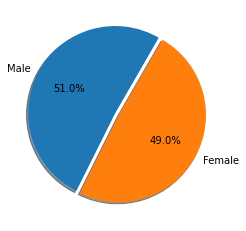

In [89]:
# Use Pandas to generate a pie plot showing the distribution of female versus male mice

#We create a dataframe out of the value counts of the column 'sex' from the original dataframe
gender_count = data_and_results["Sex"].value_counts()
#we print gender_count to see the # of male and female in the df
gender_count

#we give the strings 'male' and 'female' to the labels variable
gender = ["Male", "Female"]

#We pass the number of male and female that we printed out using 'gender count' two lines above 
#as items in the list we name 'gender count'

gender_count = [958, 922], 

#we add the explode function to create a little separation between the two sections of the pie chart
explode = (0.05, 0)

#we create the pie chart by passing in the appropriate arguments to the function
plt.pie(gender_count, explode = explode, labels = gender, autopct="%1.1f%%", shadow = True, 
        startangle=60)



## Quartiles, Outliers and Boxplots

In [90]:
# Calculate the final tumor volume of each mouse across four of the drug regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (latest) timepoint for each mouse. 

#We do this creating a dataframe composed of grouping the MouseIDs, and then looking 
#for the max timepoints to all of them to find the points at which they had their final value.

final_volume_df = data_and_results.groupby(["Mouse ID"]).max()["Timepoint"]
final_volume_df

# Merge the final_volume dataframe with the original df, on the necessary columns, creating a new df, 'tumor_df'
#which shows only the tumor_volumes which occured at the maximum timepoints.
tumor_df = pd.merge(final_volume_df, data_and_results, on = ["Mouse ID", "Timepoint"])
tumor_df

,Mouse ID,Timepoint,Drug Regimen,Sex,Age_months,Weight (g),Tumor Volume (mm3),Metastatic Sites
0,a203,45,Infubinol,Female,20,23,67.973419,2
1,a251,45,Infubinol,Female,21,25,65.525743,1
2,a262,45,Placebo,Female,17,29,70.717621,4
3,a275,45,Ceftamin,Female,20,28,62.999356,3
4,a366,30,Stelasyn,Female,16,29,63.440686,1
...,...,...,...,...,...,...,...,...
243,z435,10,Propriva,Female,12,26,48.710661,0
244,z578,45,Ramicane,Male,11,16,30.638696,0
245,z581,45,Infubinol,Female,24,25,62.754451,3
246,z795,45,Naftisol,Female,13,29,65.741070,3


In [91]:
# Put the four drug regimens into a list that can be iterated over in a for-loop 
# (and later used for plot labels)

#First, we create the list and place the items inside the list
drug_list = ["Capomulin","Ramicane", "Infubinol", "Ceftamin"]

# Create empty list to fill with tumor vol data (for plotting)
volume_list = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 

#For every drug regimen, we create a dataframe (really, a series) of two sets of values: the index is the 
#number at which the first instance of the given drug regimen appears, and the first column
#is the tumor volume at that index.

for x in drug_list:
    drug_volume = tumor_df.loc[tumor_df["Drug Regimen"] == x]["Tumor Volume (mm3)"]

    #then, we append each series that gets created from the for loop into the empty list, volume_list.
    volume_list.append(drug_volume)


    #We created a variable, 'quartiles' that runs the quantile function with .25, .5 and.75 values applied to 
    #the drug_volume dataframe
    quartiles = drug_volume.quantile([.25,.5,.75])
    #we assign names to each quartile
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    #we do the math for the lower and upper bound
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    #we print out the potential outliers for each item in the drug_volume dataframe that we've populated
    #with the relevant datapoints for upper and lower bound, within a dictionary of lists
    print(f"{x} potential outliers: {drug_volume.loc[(drug_volume < lower_bound) | (drug_volume > upper_bound)]}")
    
    # Locate the rows which contain mice on each drug and get the tumor volumes

    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds
    

Capomulin potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Ramicane potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Infubinol potential outliers: 31    36.321346
Name: Tumor Volume (mm3), dtype: float64
Ceftamin potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)


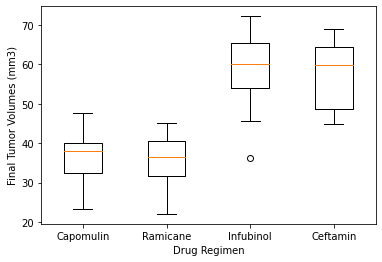

In [112]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

#We create a boxplot using the volume_list dataframe containing each drug regimen's data with corresponding labels

plt.boxplot(volume_list, labels= drug_list)
plt.ylabel("Final Tumor Volumes (mm3)")
plt.xlabel("Drug Regimen")
plt.show()


## Line and Scatter Plots

Text(0.5, 1.0, 'Reduction in tumor volume over time in Mouse s185 under Capomulin regimen')

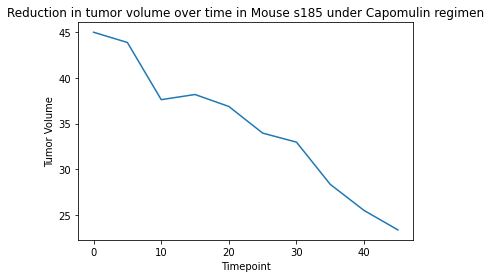

In [99]:
# Generate a line plot of tumor volume vs. timepoint for a mouse treated with Capomulin

#We create a new dataframe that is composed solely of the values in the 
#"Drug Regimen" column of the original dataframe that match the phrase, 'Capomulin'

Capomulin = data_and_results.loc[data_and_results["Drug Regimen"] == "Capomulin"]
Capomulin.head()
#We create another dataframe which are the values associated w/s185 in the Mouse ID column

s185 = Capomulin.loc[Capomulin["Mouse ID"] == "s185"]

#We plot the values from this dataframe that are contained in the Timepoint and Tumor Volumn columns
plt.plot(s185["Timepoint"], s185["Tumor Volume (mm3)"])
#and we label it appropriately
plt.ylabel("Tumor Volume")
plt.xlabel("Timepoint")
plt.title("Reduction in tumor volume over time in Mouse s185 under Capomulin regimen")

In [94]:
data_and_results.head(15)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
5,k403,Ramicane,Male,21,16,25,33.464577,1
6,k403,Ramicane,Male,21,16,30,31.099498,1
7,k403,Ramicane,Male,21,16,35,26.546993,1
8,k403,Ramicane,Male,21,16,40,24.365505,1
9,k403,Ramicane,Male,21,16,45,22.050126,1


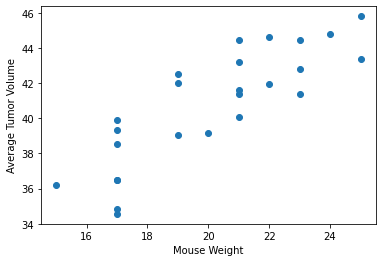

In [107]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen. 
# Note: this means mouse weight goes on the x-axis, with average tumor volume on the y-axis. 

#create a new df for the scatterplot that holds the average values of every 
#mouse so we can plot average tumor volume.

sp_Capomulin = Capomulin.groupby(["Mouse ID"]).mean()
sp_Capomulin.head()

mouse_weight = sp_Capomulin.iloc[:,1]
average_tumor_volume = sp_Capomulin.iloc[:,3]

plt.scatter(mouse_weight, average_tumor_volume)
plt.xlabel('Mouse Weight')
plt.ylabel('Average Tumor Volume')
plt.show()

#Capomulin.head()
## Correlation and Regression

The correlation coefficient between both factors is 0.84


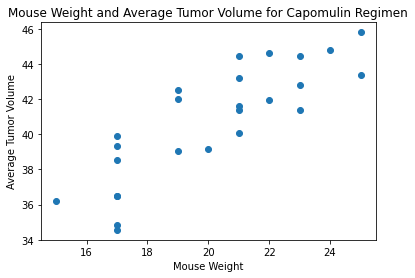

In [108]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen.

#we define the x and y values as mouse weight and avg tumor volume by using iloc to find the appropriate values
#in the Capomulin dataframe


#We pass the x and y values into the pearsonr function and call it 'correlation' for use in the print statement
correlation = st.pearsonr(mouse_weight, average_tumor_volume)

#we plot the x and y values on the scatterplot
plt.scatter(mouse_weight, average_tumor_volume)
#we label appropriately
plt.xlabel('Mouse Weight')
plt.ylabel('Average Tumor Volume')
plt.title("Mouse Weight and Average Tumor Volume for Capomulin Regimen")
#We show the correlation in the print statement, rounding to 2 decimal places
print(f"The correlation coefficient between both factors is {round(correlation[0],2)}")
plt.show()





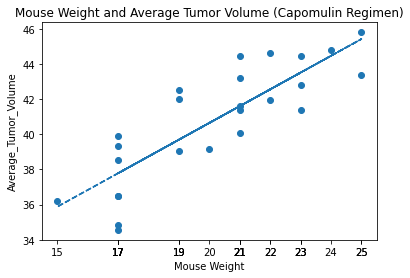

The correlation coefficient between both factors is 0.84


In [109]:
#Plot the linear regression model on top of the previous scatter plot.

#We name the variables that we will use with the stats.linregress function and pass in the x and y values

Cap_slope, Cap_int, Cap_r, Cap_p, Cap_std_err = stats.linregress(mouse_weight, average_tumor_volume)
Cap_fit = Cap_slope * mouse_weight + Cap_int

#We plot the x and y values in a scatterplot
plt.scatter(mouse_weight, average_tumor_volume)

#We plot the x value and the cap_fit value to create the regression, passing in the dotted line as well
plt.plot(mouse_weight, Cap_fit,"--")

#We add ticks and label appropriately
plt.xticks(mouse_weight)
plt.xlabel('Mouse Weight')
plt.ylabel('Average_Tumor_Volume')
plt.title("Mouse Weight and Average Tumor Volume (Capomulin Regimen)")
plt.show()
print(f"The correlation coefficient between both factors is {round(correlation[0],2)}")